# xforms with Tensorflow

This notebook demonstrates the use of xforms for generating models that are easy to reload, using tensorflow as the fitter. The process is very similar to normal workflows, except when specifying the fitter, `fit_tf` rather than `fit_basic` is used.

In [1]:
import logging
from pathlib import Path

import nems.db as db
import nems.modelspec as ms
import nems.recording as recording
import nems.uri
import nems.xforms as xforms

[nems.configs.defaults INFO] Saving log messages to /tmp/nems\NEMS 2020-05-28 133629.log


## Configuration

In [2]:
# get the data and results paths
results_dir = nems.get_setting('NEMS_RESULTS_DIR')
signals_dir = nems.get_setting('NEMS_RECORDINGS_DIR')

In [3]:
# download some demo data
recording.get_demo_recordings(signals_dir)
datafile = Path(signals_dir) / 'TAR010c-18-1.pkl'

## Data Loading and Preprocessing

In [4]:
load_command = 'nems.demo.loaders.demo_loader'
expt_id = 'TAR010c'
batch = 271
cell_id = 'TAR010c-18-1'

In [5]:
modelspec_name = 'dlog-wc.18x1.g-fir.1x15-lvl.1-dexp.1'

## Generate the Modelspec

Each item in the xform spec is a call to a function along with the arguments for that function.

In [6]:
xfspec = []

In [7]:
# load from external format
xfspec.append(['nems.xforms.load_recording_wrapper', 
               {'load_command': load_command,
                'exptid': expt_id,
                'datafile': str(datafile)
               }])

In [8]:
# split the data into est and val
xfspec.append(['nems.xforms.split_by_occurrence_counts',
               {'epoch_regex': '^STIM_'}])

In [9]:
xfspec.append(['nems.xforms.average_away_stim_occurrences', {}])

In [10]:
meta = {'cellid': cell_id, 'batch': batch, 'modelname': modelspec_name, 'recording': expt_id}

xfspec.append(['nems.xforms.init_from_keywords',
               {'keywordstring': modelspec_name,
                'meta': meta
               }])

In [11]:
# init, then fit
xfspec.append(['nems.tf.cnnlink.fit_tf_init', {}])
xfspec.append(['nems.tf.cnnlink.fit_tf', {}])

In [12]:
xfspec.append(['nems.xforms.predict', {}])

In [13]:
# test prediction then visualize
xfspec.append(['nems.analysis.api.standard_correlation', {},
               ['est', 'val', 'modelspec', 'rec'], ['modelspec']])
xfspec.append(['nems.xforms.plot_summary', {}])

## Run the Analysis

[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file C:\Users\Alex\PycharmProjects\NEMS\recordings\TAR010c_afb264b3db970ec890e04c727e612c1cbfaced62.tgz
[nems.xforms INFO] Evaluating: nems.xforms.split_by_occurrence_counts
[nems.xforms INFO] Evaluating: nems.xforms.average_away_stim_occurrences
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: dlog
[nems.initializers INFO] kw: wc.18x1.g
[nems.initializers INFO] kw: fir.1x15
[nems.initializers INFO] kw: lvl.1
[nems.initializers INFO] kw: dexp.1
[nems.initializers INFO] Setting modelspec[0] input to stim
[nems.xforms INFO] Evaluating: nems.tf.cnnlink.fit_tf_init
[nems.tf.cnnlink INFO] target_module: ['levelshift', 'relu'] found at modelspec[3].
[nems.tf.cnnlink INFO] Mod 3 (nems.modules.levelshift.levelshift) fixing level to resp mean 0.207
[nems.tf.cnnlink INFO] resp has 1 channels
[nems.tf.cnnlink INFO] nems.modules.nonlinearity.dlog
nems.module

bin range: 0-500


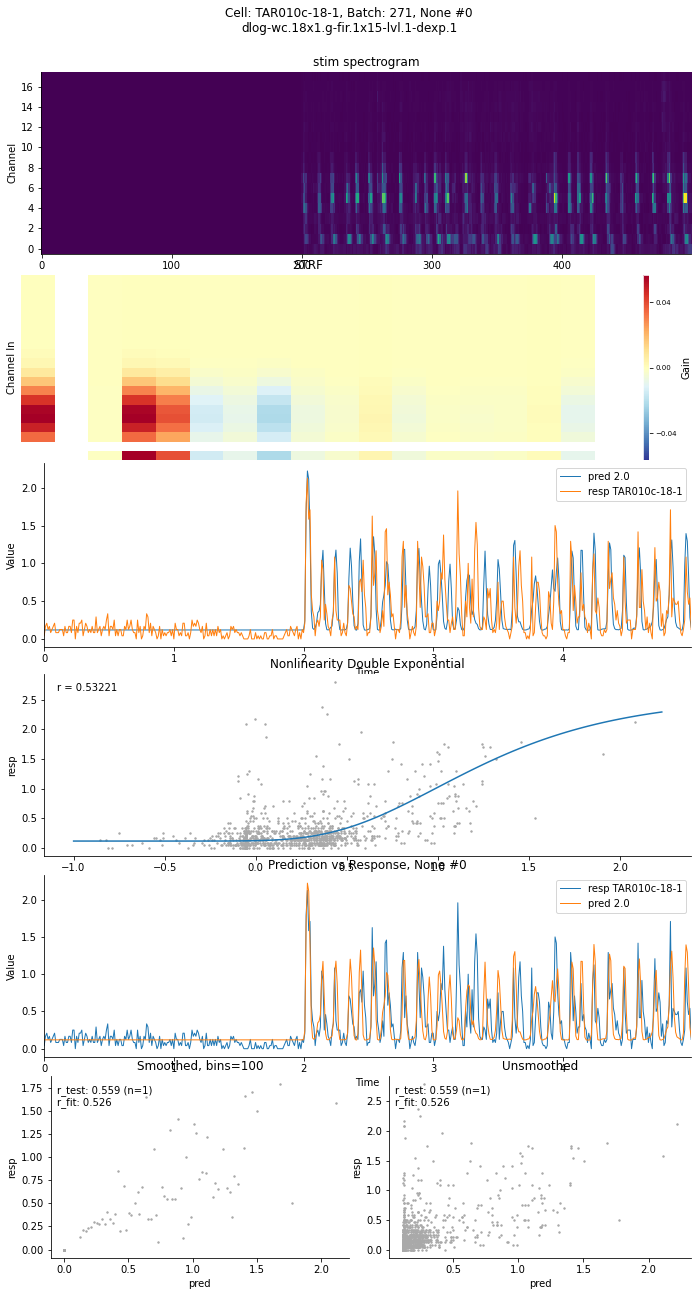

In [14]:
ctx = {}
for xfa in xfspec:
    ctx = xforms.evaluate_step(xfa, ctx)